In [1]:
# Compute uvgeo from SSH
# Import necessary modules
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
import os
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.ticker as mticker


folder_data = "/Odyssey/private/t22picar/data/glorys_15m/"
file_glorys = "glorys_15.81m_2019-01-01-2020-01-01.nc"
maps_glorys = xr.open_dataset(folder_data+file_glorys)
maps_glorys

# Get longitudes and latitudes
lon = maps_glorys.longitude.values
lat = maps_glorys.latitude.values
lon2D, lat2D = numpy.meshgrid(lon, lat)


In [5]:
xr.plot.hist(maps_glorys)

AttributeError: 'Dataset' object has no attribute 'ndim'

In [2]:
folder_data = "/Odyssey/private/t22picar/data/ssh_L4/SSH_L4_CMEMS_2019.nc"
maps_l4 = xr.open_dataset(folder_data)
#maps_l4

# Get longitudes and latitudes
lon_l4 = maps_l4.longitude.values
lat_l4 = maps_l4.latitude.values
lon2D_l4, lat2D_l4 = numpy.meshgrid(lon_l4, lat_l4)

In [3]:
maps_l4

<xarray.Dataset> Size: 49GB
Dimensions:    (time: 366, latitude: 1440, longitude: 2880)
Coordinates:
  * latitude   (latitude) float32 6kB -89.94 -89.81 -89.69 ... 89.69 89.81 89.94
  * longitude  (longitude) float32 12kB -179.9 -179.8 -179.7 ... 179.8 179.9
  * time       (time) datetime64[ns] 3kB 2019-01-01 2019-01-02 ... 2020-01-01
Data variables:
    adt        (time, latitude, longitude) float64 12GB ...
    sla        (time, latitude, longitude) float64 12GB ...
    ugos       (time, latitude, longitude) float64 12GB ...
    vgos       (time, latitude, longitude) float64 12GB ...
Attributes:
    comment:                   Sea Surface Height measured by Altimetry and d...
    source:                    Altimetry measurements
    Conventions:               CF-1.6
    history:                   2024-10-23 12:55:06Z: Creation
    references:                http://marine.copernicus.eu
    title:                     DT merged all satellites Global Ocean Gridded ...
    institution:               CLS, CNES
    contact:                   servicedesk.cmems@mercator-ocean.eu
    copernicusmarine_version:  2.0.1

In [2]:
num_diff = 2  # Usual value is 2
num_centered = num_diff // 2

def compute_uvgeo(time_index):

    # 
    ssh = maps.zos.values[time_index,:]


    # Mask invalid SSH values
    ssh[abs(ssh) > 100] = numpy.nan

    # Initialize null matrices
    ugeo = numpy.full(numpy.shape(ssh), 0.)
    vgeo = numpy.full(numpy.shape(ssh), 0.)

    # Compute g/f
    goverf = constant_g / (constant_f0 * numpy.sin(numpy.deg2rad(lat2D)))

    # Compute derivatives
    dsshy = ssh[num_diff:, :] - ssh[:-num_diff, :]
    dsshx = ssh[:, num_diff:] - ssh[:, :-num_diff]
    dlonx = (
        (lon2D[:,num_diff:] - lon2D[:,:-num_diff])
        * numpy.cos(numpy.deg2rad(lat2D[:, num_centered:-num_centered]))
        * degtom
    )
    dlaty = (lat2D[num_diff:,:] - lat2D[:-num_diff,:]) * degtom

    # Compute geostrophic velocities
    ugeo[num_centered:-num_centered, :] = -goverf[num_centered:-num_centered, :] * dsshy / dlaty
    vgeo[:, num_centered:-num_centered] = goverf[:, num_centered:-num_centered] * dsshx / dlonx

    # Mask invalid values 
    #ugeo = numpy.ma.array(ugeo, mask=((abs(ugeo)>10)))
    #vgeo = numpy.ma.array(vgeo, mask=((abs(vgeo)>10)))

    #Mask close to the equator
    ugeo = numpy.ma.array(ugeo, mask=((abs(lat2D)<10)))
    vgeo = numpy.ma.array(vgeo, mask=((abs(lat2D)<10)))

    return(ugeo,vgeo)

In [3]:
# Compute first time step
(ugeo,vgeo) = compute_uvgeo(0) 
norm_uv = numpy.sqrt(ugeo**2 + vgeo**2)

/tmp/ipykernel_1759723/1598655032.py:18: RuntimeWarning: divide by zero encountered in divide
  goverf = constant_g / (constant_f0 * numpy.sin(numpy.deg2rad(lat2D)))
/tmp/ipykernel_1759723/1598655032.py:31: RuntimeWarning: invalid value encountered in multiply
  ugeo[num_centered:-num_centered, :] = -goverf[num_centered:-num_centered, :] * dsshy / dlaty
/tmp/ipykernel_1759723/1598655032.py:32: RuntimeWarning: invalid value encountered in multiply
  vgeo[:, num_centered:-num_centered] = goverf[:, num_centered:-num_centered] * dsshx / dlonx
/tmp/ipykernel_1759723/2837517671.py:3: RuntimeWarning: invalid value encountered in sqrt
  norm_uv = numpy.sqrt(ugeo**2 + vgeo**2)


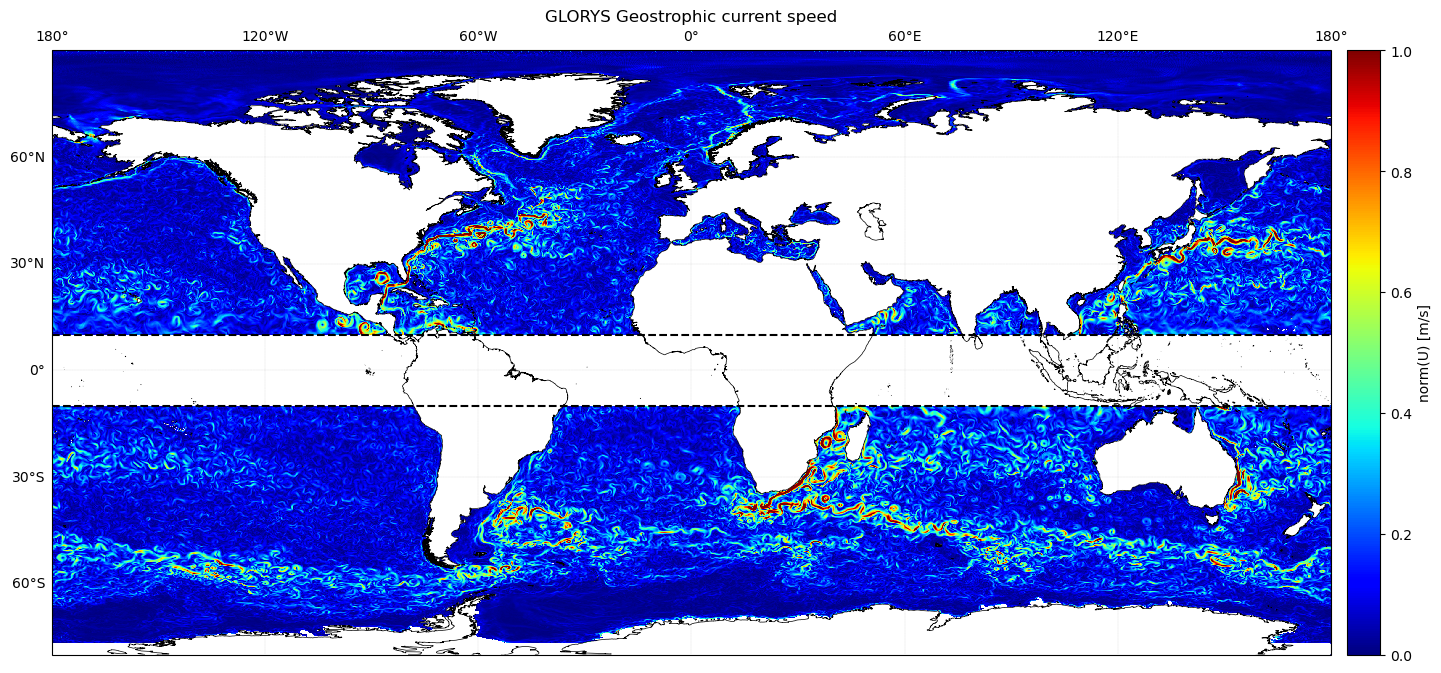

In [4]:
import warnings
warnings.filterwarnings("ignore")


fig, axs = plt.subplots(nrows=1,ncols=1,
                    subplot_kw={'projection': ccrs.PlateCarree()},
                    figsize=(11*1.5,7.5*1.5))

axs.hlines(lat_mask,-180,180,color='k', alpha=1, linestyle='--')
axs.hlines(-lat_mask,-180,180,color='k', alpha=1, linestyle='--')

plt.title('GLORYS Geostrophic current speed')

#p0 = plt.pcolormesh(lon2D, lat2D, norm_uv, cmap='jet',vmax=1)
p0 = plt.pcolormesh(lon2D, lat2D, norm_uv, cmap='jet',vmax=1)  

axs.coastlines(resolution='10m', lw=0.5)
#axs.add_feature(cfeature.LAND.with_scale('50m'), facecolor='#EEEEEE', edgecolor='face',alpha=1)

# optional add grid lines
p0.axes.gridlines(color='black', alpha=0., linestyle='--')

# draw parallels/meridiens and write labels
gl = p0.axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                        linewidth=0.1, color='black', alpha=0.5, linestyle='--')
# adjust labels to taste
gl.top_labels = True
gl.right_labels = False
gl.bottom_labels = False
gl.left_labels = True
#gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
#gl.xlocator = mticker.FixedLocator([-180, -60, 0,  60, 180])
gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}

#get size and extent of axes:
axpos = axs.get_position()
pos_x = axpos.x0+axpos.width + 0.01# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.02
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height!
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
cbar=plt.colorbar(p0, cax=pos_cax)
cbar.set_label('norm(U) [m/s]')

#cax = fig.add_axes([0.92, 0.37, 0.02, 0.25])
#cbar = fig.colorbar(p0, cax=axs, orientation='vertical')
#cax.set_ylabel('Number of data', fontweight='bold')



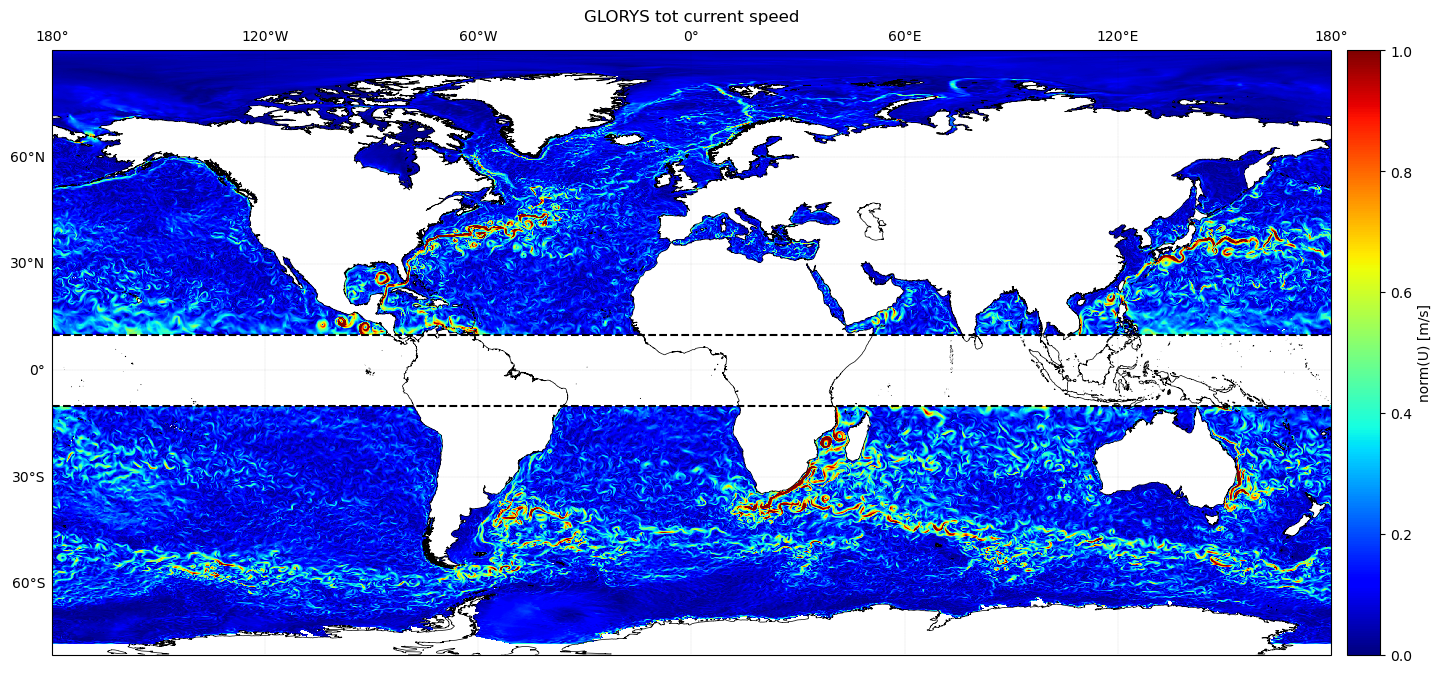

In [5]:
norm_uv = numpy.sqrt(maps.uo.values[0,0,:]**2 + maps.vo.values[0,0,:]**2)
#Mask close to the equator
norm_uv = numpy.ma.array(norm_uv, mask=((abs(lat2D)<10)))

import warnings
warnings.filterwarnings("ignore")


fig, axs = plt.subplots(nrows=1,ncols=1,
                    subplot_kw={'projection': ccrs.PlateCarree()},
                    figsize=(11*1.5,7.5*1.5))

axs.hlines(lat_mask,-180,180,color='k', alpha=1, linestyle='--')
axs.hlines(-lat_mask,-180,180,color='k', alpha=1, linestyle='--')

plt.title('GLORYS tot current speed')

#p0 = plt.pcolormesh(lon2D, lat2D, norm_uv, cmap='jet',vmax=1)
p0 = plt.pcolormesh(lon2D, lat2D, norm_uv, cmap='jet',vmax=1)  

axs.coastlines(resolution='10m', lw=0.5)
#axs.add_feature(cfeature.LAND.with_scale('50m'), facecolor='#EEEEEE', edgecolor='face',alpha=1)

# optional add grid lines
p0.axes.gridlines(color='black', alpha=0., linestyle='--')

# draw parallels/meridiens and write labels
gl = p0.axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                        linewidth=0.1, color='black', alpha=0.5, linestyle='--')
# adjust labels to taste
gl.top_labels = True
gl.right_labels = False
gl.bottom_labels = False
gl.left_labels = True
#gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
#gl.xlocator = mticker.FixedLocator([-180, -60, 0,  60, 180])
gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}

#get size and extent of axes:
axpos = axs.get_position()
pos_x = axpos.x0+axpos.width + 0.01# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.02
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height!
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
cbar=plt.colorbar(p0, cax=pos_cax)
cbar.set_label('norm(U) [m/s]')

#cax = fig.add_axes([0.92, 0.37, 0.02, 0.25])
#cbar = fig.colorbar(p0, cax=axs, orientation='vertical')
#cax.set_ylabel('Number of data', fontweight='bold')